# Visual Firewall – CIC‑IDS‑2017 → GAF Image Encoder

In [2]:
# ▶️ If you're running this on a fresh Python/Jupyter environment,
#    uncomment the next line to install required libs.
# !pip install pandas scikit-learn pyts opencv-python tqdm


In [3]:
import os, glob
from pathlib import Path
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from pyts.image import GramianAngularField
import cv2
from tqdm import tqdm


In [4]:
# 🔧 Configuration
DATA_DIR   = Path('data')          # folder with *.csv
OUT_DIR    = Path('gaf_images')    # images + labels.csv will be written here
IMG_SIZE   = 32                    # 32×32 images
FEATURES = [
    # ─── traffic volumes ───────────────────────────────────────────
    "Flow Duration",
    "Total Fwd Packets", "Total Backward Packets",
    "Total Length of Fwd Packets", "Total Length of Bwd Packets",

    # ─── packet-length statistics ─────────────────────────────────
    "Fwd Packet Length Max", "Fwd Packet Length Min",
    "Fwd Packet Length Mean", "Fwd Packet Length Std",
    "Bwd Packet Length Max", "Bwd Packet Length Min",
    "Bwd Packet Length Mean", "Bwd Packet Length Std",

    # ─── throughput & rate features ───────────────────────────────
    "Flow Bytes/s", "Flow Packets/s",
    "Fwd Packets/s", "Bwd Packets/s",

    # ─── inter-arrival-time (IAT) stats ───────────────────────────
    "Flow IAT Mean", "Flow IAT Std", "Flow IAT Max", "Flow IAT Min",
    "Fwd IAT Total", "Fwd IAT Mean", "Fwd IAT Std", "Fwd IAT Max", "Fwd IAT Min",
    "Bwd IAT Total", "Bwd IAT Mean", "Bwd IAT Std", "Bwd IAT Max", "Bwd IAT Min",

    # ─── aggregate packet-size stats ──────────────────────────────
    "Min Packet Length", "Max Packet Length",
    "Packet Length Mean", "Packet Length Std",

    # ─── TCP flag counters (binary patterns often signal attacks) ─
    "FIN Flag Count", "SYN Flag Count", "RST Flag Count",
    "PSH Flag Count", "ACK Flag Count", "URG Flag Count"
]

OUT_DIR.mkdir(exist_ok=True)


In [5]:
def load_cic_csv(dir_path: Path) -> pd.DataFrame:
    files = glob.glob(str(dir_path / 'Friday-WorkingHours-Afternoon-DDos.pcap_ISCX.csv'))
    if not files:
        raise FileNotFoundError(f'No CSV files found in {dir_path.resolve()}')
    dfs = [pd.read_csv(f, low_memory=False) for f in files]
    return pd.concat(dfs, ignore_index=True)

def encode_gaf_pair(signal: np.ndarray, size: int):
    gadf = GramianAngularField(method='difference', image_size=size).fit_transform(signal.reshape(1,-1))[0]
    gasf = GramianAngularField(method='summation', image_size=size).fit_transform(signal.reshape(1,-1))[0]
    return gadf, gasf

def save_rgb(gadf: np.ndarray, gasf: np.ndarray, save_path: Path):
    gadf_u8 = ((gadf + 1) / 2 * 255).astype(np.uint8)
    gasf_u8 = ((gasf + 1) / 2 * 255).astype(np.uint8)
    b = np.zeros_like(gadf_u8, dtype=np.uint8)
    rgb = cv2.merge([gadf_u8, gasf_u8, b])
    cv2.imwrite(str(save_path), rgb)


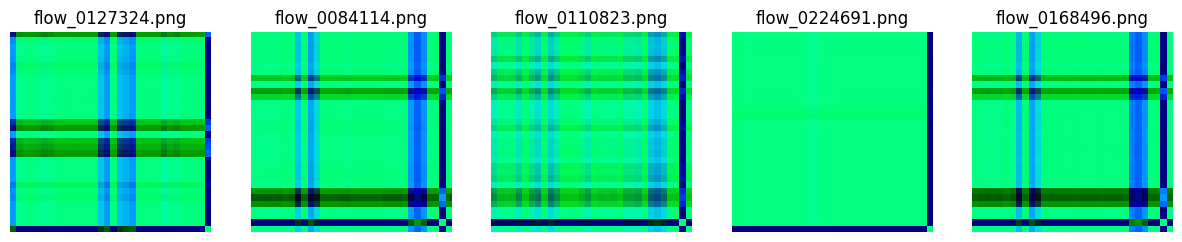

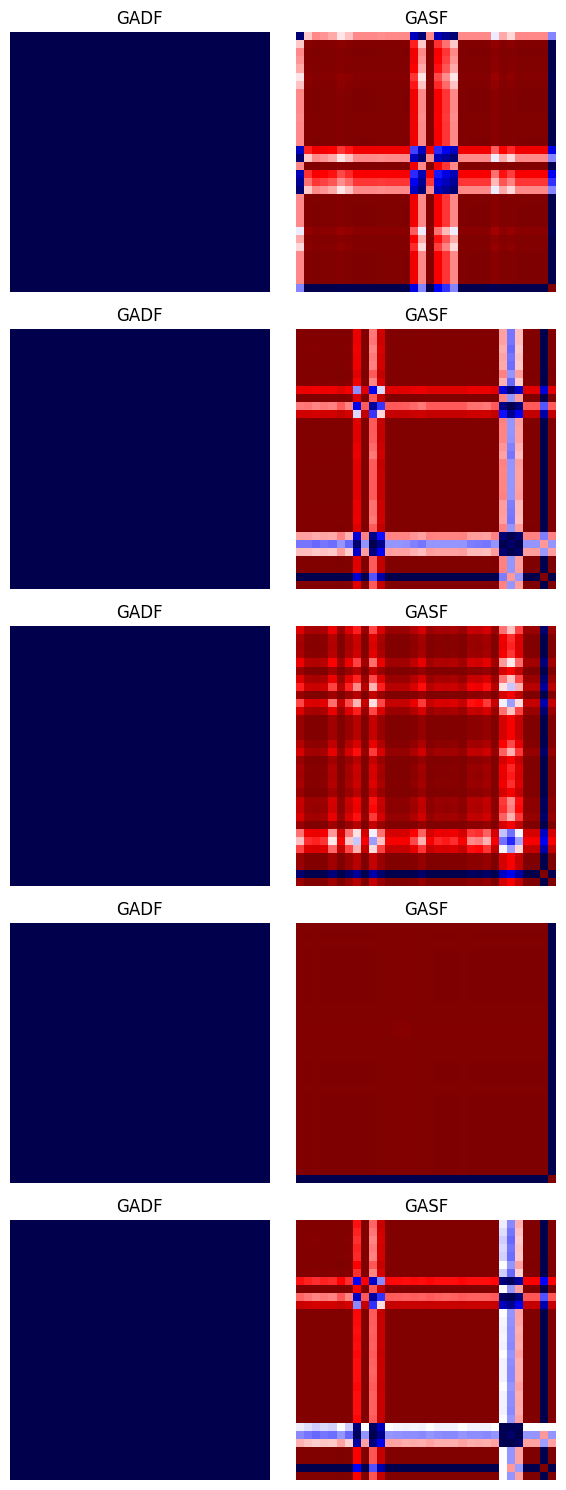

In [18]:
# 🔍 Visual sanity‑check – display a few random images
import random, matplotlib.pyplot as plt

samples = random.sample(list(Path(OUT_DIR).glob('*.png')), 5)
fig, axs = plt.subplots(1, len(samples), figsize=(15,3))
for ax, img_path in zip(axs, samples):
    img = cv2.imread(str(img_path))        # BGR uint8
    rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Display the composite (same as before)
    ax.imshow(rgb)
    ax.set_title(img_path.name)
    ax.axis('off')

plt.show()

# ↓ NEW block: inspect channels
fig2, ax2 = plt.subplots(len(samples), 2, figsize=(6, 3*len(samples)))
for row, img_path in enumerate(samples):
    img = cv2.imread(str(img_path))
    gadf = img[:, :, 2]        # R channel became index 2 after BGR→RGB
    gasf = img[:, :, 1]        # G channel
    ax2[row, 0].imshow(gadf, cmap='seismic'); ax2[row, 0].set_title('GADF')
    ax2[row, 1].imshow(gasf, cmap='seismic'); ax2[row, 1].set_title('GASF')
    for c in (0,1): ax2[row, c].axis('off')
plt.tight_layout(); plt.show()



In [12]:
df = load_cic_csv(DATA_DIR)
# quick diagnostic for your chosen FEATURES
df.columns = df.columns.str.strip()
df[FEATURES] = df[FEATURES].replace(
    regex=r'(?i)inf|-inf|infinity|-infinity',  # (?i) = case-insensitive
    value=np.nan
)

# Convert selected columns to numeric (coerce errors to NaN)
df[FEATURES] = df[FEATURES].apply(pd.to_numeric, errors="coerce")

# 3) Clip absurdly large magnitudes that can survive as finite floats
abs_cap = 1e12         # adjust if you need higher; IDS features rarely exceed this
df[FEATURES] = df[FEATURES].clip(lower=-abs_cap, upper=abs_cap)

df = df.dropna(subset=FEATURES).reset_index(drop=True)

# scale features to [-1,1] for GAF
scaler = MinMaxScaler(feature_range=(-1,1))
df[FEATURES] = scaler.fit_transform(df[FEATURES])
label_map = []
for idx, row in tqdm(df.iterrows(), total=len(df)):
    vec = row[FEATURES].values.astype(np.float32)
    gadf, gasf = encode_gaf_pair(vec, IMG_SIZE)
    img_name = f'flow_{idx:07d}.png'
    save_rgb(gadf, gasf, OUT_DIR / img_name)
    label_map.append({'image': img_name, 'label': row['Label']})

pd.DataFrame(label_map).to_csv(OUT_DIR / 'labels.csv', index=False)
print('✅ Done:', len(label_map), 'images written to', OUT_DIR)


  0%|          | 908/225741 [00:02<08:55, 420.05it/s] 


KeyboardInterrupt: 

In [7]:
# 📦 Quick PyTorch dataset wrapper
from torch.utils.data import Dataset
from PIL import Image
import torchvision.transforms as T

class FlowGAFDataset(Dataset):
    def __init__(self, img_dir=OUT_DIR, csv_file=OUT_DIR/'labels.csv', transform=None):
        self.df = pd.read_csv(csv_file)
        self.img_dir = Path(img_dir)
        self.transform = transform or T.ToTensor()
    def __len__(self): return len(self.df)
    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img = Image.open(self.img_dir / row.image).convert('RGB')
        label = row.label
        return self.transform(img), label

print('Dataset demo:', len(FlowGAFDataset()), 'samples')


Dataset demo: 225741 samples
